<a href="https://colab.research.google.com/github/kaleetock/exoplanets/blob/main/HIP_65ab_phot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import numpy as np
import os
import re
import math
from astropy import units as u
import matplotlib.pyplot


Mounted at /content/drive


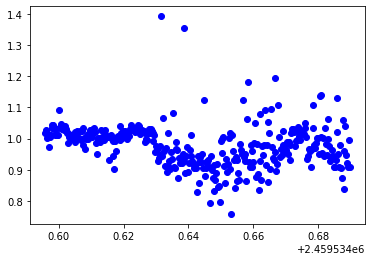

In [14]:
def parse_filename(f):
  m = re.search( r'(([a-zA-Z0-9]+)_([aBVirpguzsw]+)_(\d+)d(\d+)_(\d\d\d\dd\d\dd\d\d)T\d\dd\d\dd\d\dd\d+\_(\d)a([\d]+)_(\d+)d(\d+)_([A-Za-z0-9]+)\_(\w+)\.(\w+))', f )  

  if m:
    file_prefix = m.group(1)
    target = m.group(2)
    filter_color = m.group(3)
    bjd_timestamp = float(m.group(4)+"."+m.group(5))
    date = m.group(6)
    airmass = float(m.group(7)+"."+m.group(8))
    exposure_time = float(m.group(9)+"."+m.group(10))
    telescope = m.group(11)
    user = m.group(12)
    phot = m.group(13)
    
    m2 = re.search( r'(.*?)MEDSTACK$', target)
    if m2:
      target = m2.group(1)

    return(target, filter_color, bjd_timestamp, date, airmass, exposure_time, telescope, user, phot)

  else:
    print(f"Could not parse filename {f}!")

############################################

# Divides all fluxes *and all flux errors* by the average baseline, out-of-transit flux.
# (I *think* it is correct to use the same scale factor for errors as for the quantity of interest?)

def normalize(ingress_begin, egress_end, datafile, normalized_datafile):
  baseline = []
  with open(datafile, "r") as f:
    for line in f:
      bjd, flux, flux_err, airmass = line.split(",")
      bjd, flux, flux_err, airmass = float(bjd), float(flux), float(flux_err), float(airmass)
      if bjd < ingress_begin or bjd > egress_end: 
        baseline.append(flux)
    num_baseline, avg_baseline = len(baseline), np.mean(baseline)
  
  bjds, normalized_fluxes = [], []
  with open(normalized_datafile, "w") as normalized:
    with open(datafile, "r") as f:
      for line in f:
        bjd, flux, flux_err, airmass = line.split(",")
        bjd, flux, flux_err, airmass = float(bjd), float(flux), float(flux_err), float(airmass)
        flux /= avg_baseline
        flux_err /= avg_baseline
        normalized.write(str(f"{bjd}, {flux}, {flux_err}, {airmass}\n"))
        bjds.append(bjd)
        normalized_fluxes.append(flux)
  return(bjds, normalized_fluxes)

############################################

def find_phot(target_ra, target_dec, comp_ra, comp_dec, min_dist, path, outpath):
  files = [f for f in sorted(os.listdir(path)) if os.path.isfile(os.path.join(path,f))]
  filenum, num_files = 0, len(files)
  with open(outpath, "w") as out:
    for f in files:
      filenum += 1
#      print(f"filenum {filenum} of {num_files}")
      (target, filter_color, bjd_timestamp, date, airmass, exposure_time, telescope, user, phot) = parse_filename(f)
      target_found, comp_found, target_counts, target_counts_err, comp_counts, comp_counts_err = False, False, 0, 0, 0, 0

      num_lines = 0
      min_t, min_c = 1000000, 1000000
      with open (os.path.join(path, f), "r") as phot:
        for line in phot:
          num_lines += 1
          ra, dec, x, y, count, counts_err, u1, u2 = line.split(",")
          ra, dec, counts, counts_err = float(ra), float(dec), float(count), float(counts_err)

          if abs(ra - target_ra) < min_dist and abs(dec - target_dec) < min_dist and abs(ra - target_ra) < min_t and abs(dec - target_dec) < min_t:
            target_found, target_counts, target_counts_err = True, counts, counts_err

          if abs(ra - comp_ra) < min_dist and abs(dec - comp_dec) < min_dist and abs(ra - comp_ra) < min_c and abs(dec - comp_dec) < min_c:
            comp_found, comp_counts, comp_counts_err = True, counts, counts_err

        if target_counts > 0 and comp_counts > 0 and target_counts_err > 0 and comp_counts_err > 0:
          diff_flux = target_counts / comp_counts
          x, y, sig_x, sig_y = target_counts, comp_counts, target_counts_err, comp_counts_err
          diff_flux_err = math.sqrt((sig_x**2) * ((1/y)**2) + (sig_y**2) * (-x/(y**2))**2)
          # Error on differential flux uses reference from Kyle (Aug 20 Slack)

          outstr = str(f"{bjd_timestamp}, {diff_flux}, {diff_flux_err}, {airmass}")
          out.write(outstr+"\n")
      # print(f"file {filenum}: {num_lines} lines")

############################################

# Coordinates: 
# HIP65ab	0.1859583333 -54.8308277778
# Comp1 0.2392958333  -54.755633333
# Comp2 0.1571458333 -54.8613027778

target_ra, target_dec, comp_ra, comp_dec, min_dist = 0.1859583333, -54.8308277778, 0.2392958333, -54.755633333, 0.001
path = "/content/drive/MyDrive/2022 Astronomy Research Seminar/0.Teams/best hip team hip drive/Hip65ab_psx"  # uploaded unzipped folder to sex dir
outpath = "/content/drive/MyDrive/2022 Astronomy Research Seminar/0.Teams/best hip team hip drive/Hip65ab_phot"
raw_outpath = os.path.join(outpath, "Comp1.csv")

find_phot(target_ra, target_dec, comp_ra, comp_dec, min_dist, path, raw_outpath)

predicted_midpoint = 2459534.663409  # This is the predicted midpoint on the night of the observations (June 24)
transit_duration_in_hours = 1.2  

normalized_outpath = os.path.join(outpath, "Comp1_Normalized.csv")
ingress_begin = predicted_midpoint - (transit_duration_in_hours / (24*2))
egress_end = predicted_midpoint + (transit_duration_in_hours / (24*2))

(bjds, normalized_fluxes) = normalize(ingress_begin, egress_end, raw_outpath, normalized_outpath)

# Plot the data to check appearance and normalization

%matplotlib inline
matplotlib.pyplot.plot(bjds, normalized_fluxes, 'bo')